In [1]:
import tensorflow as tf
import numpy as np


# In[112]:
num_classes = 513
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

class Model:
    
    def __init__(self):
        pass
    
    def _init_and_build_net(self):
        tf.reset_default_graph()
        tf.initialize_all_variables()
        sess = tf.Session()
        self.sess = sess
        self._build_net_2()
        sess.run(tf.global_variables_initializer())
        
    def _save_network(self):
        saver = tf.train.Saver()
        saver.save(self.sess, './hangeul_cnn.ckpt')
    
    def weight_variable(self, shape):
        initial = tf.random.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def _restore_network(self):
        self.sess = tf.InteractiveSession()
        saver = tf.train.import_meta_graph('./hangeul_cnn.ckpt.meta')
        saver.restore(self.sess,'./hangeul_cnn.ckpt')
        
        graph = tf.get_default_graph()
        self.X =  self.sess.graph.get_tensor_by_name("Placeholder:0")
        self.Y =  self.sess.graph.get_tensor_by_name("Placeholder_1:0")
        self.W_conv1 = self.sess.graph.get_tensor_by_name("W1:0")
        self.W_conv2 = self.sess.graph.get_tensor_by_name("W2:0")
        self.W_conv3 = self.sess.graph.get_tensor_by_name("W3:0")
        self.b_conv1 = self.sess.graph.get_tensor_by_name("Variable:0")
        self.b_conv2 = self.sess.graph.get_tensor_by_name("Variable_1:0")
        self.b_conv3 = self.sess.graph.get_tensor_by_name("Variable_2:0")
        self.cross_entropy = self.sess.graph.get_tensor_by_name("Mean:0")
        self.train_step = self.sess.graph.get_operation_by_name("Adam")
        self.accuracy = self.sess.graph.get_tensor_by_name("Mean_1:0")
        self.W_fc1 = self.sess.graph.get_tensor_by_name("W4:0")
        self.b_fc1 = self.sess.graph.get_tensor_by_name("Variable_3:0")
        self.W_fc2 = self.sess.graph.get_tensor_by_name("W5:0")
        self.b_fc2 = self.sess.graph.get_tensor_by_name("Variable_4:0")
        self.y_logits = self.sess.graph.get_tensor_by_name("add_4:0")
        self.keep_prob =  self.sess.graph.get_tensor_by_name("Placeholder_2:0")
        
    def _build_net_2(self):
        self.X = tf.placeholder(tf.float32, [None, IMAGE_WIDTH*IMAGE_HEIGHT])
        self.Y = tf.placeholder(tf.float32, [None, num_classes])

        # Reshape the image back into two dimensions so we can perform convolution.
        x_image = tf.reshape(self.X, [-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1])

        #self.W_conv1 = self.weight_variable([5, 5, 1, 32])
        self.W_conv1 = tf.get_variable("W1", shape=[5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer())
        
        self.b_conv1 = self.bias_variable([32])
        x_conv1 = tf.nn.conv2d(x_image, self.W_conv1, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv1 = tf.nn.relu(x_conv1 + self.b_conv1)

        # Max-pooling.
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional layer. 64 feature maps.
        
        #self.W_conv2 = self.weight_variable([5, 5, 32, 64])
        self.W_conv2  = tf.get_variable("W2", shape=[5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
        self.b_conv2 = self.bias_variable([64])
        x_conv2 = tf.nn.conv2d(h_pool1, self.W_conv2, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv2 = tf.nn.relu(x_conv2 + self.b_conv2)

        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Third convolutional layer. 128 feature maps.
        
        #self.W_conv3 = self.weight_variable([3, 3, 64, 128])
        self.W_conv3  = tf.get_variable("W3", shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer())
        self.b_conv3 = self.bias_variable([128])
        x_conv3 = tf.nn.conv2d(h_pool2, self.W_conv3, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv3 = tf.nn.relu(x_conv3 + self.b_conv3)

        h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Fully connected layer. Here we choose to have 1024 neurons in this layer.
        h_pool_flat = tf.reshape(h_pool3, [-1, 8*8*128])
        #self.W_fc1 = self.weight_variable([8*8*128, 1024])
        self.W_fc1 = tf.get_variable("W4", shape=[8*8*128, 1024], initializer=tf.contrib.layers.xavier_initializer())
        self.b_fc1 = self.bias_variable([1024])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, self.W_fc1) + self.b_fc1)

        # Dropout layer. This helps fight overfitting.
        self.keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, rate=1-self.keep_prob)

        # Classification layer.
        #self.W_fc2 = self.weight_variable([1024, num_classes])
        self.W_fc2 = tf.get_variable("W5", shape=[1024, num_classes], initializer=tf.contrib.layers.xavier_initializer())
        self.b_fc2 = self.bias_variable([num_classes])
        self.y_logits = tf.matmul(h_fc1_drop, self.W_fc2) + self.b_fc2

        # This isn't used for training, but for when using the saved model.
        tf.nn.softmax(self.y_logits)

        # Define our loss.
        self.cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf.stop_gradient(self.Y),
                logits=self.y_logits
            )
        )

        # Define our optimizer for minimizing our loss. Here we choose a learning
        # rate of 0.0001 with AdamOptimizer. This utilizes someting
        # called the Adam algorithm, and utilizes adaptive learning rates and
        # momentum to get past saddle points.
        self.train_step = tf.train.AdamOptimizer(0.001).minimize(self.cross_entropy)

        # Define accuracy.
        correct_prediction = tf.equal(tf.argmax(self.y_logits, 1), tf.argmax(self.Y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        self.accuracy = tf.reduce_mean(correct_prediction)
        print("net_complete")
        
    
    
    def result_to_str(self, x_test):
        return str(self.sess.run(tf.argmax(self.y_logits, 1), feed_dict={self.X: x_test, self.keep_prob: 1.0})[0])
    
    def predict(self, x_test):
        return self.sess.run(self.y_logits, feed_dict={self.X: x_test, self.keep_prob: 1.0})
    
    def get_accuracy(self):
        x_test = np.load('hangeul_test_input.npy')
        y_test = np.load('hangeul_test_label.npy')
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: 1.0})
    
    def train(self, x_data, y_data):
        return self.sess.run([self.cross_entropy, self.train_step], feed_dict={self.X: x_data, self.Y: y_data, self.keep_prob: 0.5})
    
    def training(self, epochs, input_name, label_name):
        training_epochs = epochs
        batch_size = 100
        
        train_input = np.load(input_name)
        train_label = np.load(label_name)
        
        print('Learning Started!')

        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(len(train_input) / batch_size)
 
            for i in range(total_batch):
                start = ((i+1) * batch_size) - batch_size
                end = ((i+1) * batch_size)
                batch_xs = train_input[start:end]
                batch_ys = train_label[start:end]
                
                #if i%100 == 0:
                #    train_accuracy = self.sess.run(self.accuracy, feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 1.0})
                #    print("Step %d, Training Accuracy %g" %(i, float(train_accuracy)))
                c, _ = self.train(batch_xs, batch_ys)
                avg_cost += c / total_batch
 
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
 
        print('Learning Finished!')



In [2]:
import shutil
import cv2
import matplotlib.pyplot as plt

hangeul_order_list = []
result_list = ""
def make_order_list():
    global hangeul_order_list
    ORDER_FILE_PATH = "C:/DataSet/Hangeul/order.txt"
    order_file = open(ORDER_FILE_PATH, 'r')
    hangeul_order_list = order_file.readlines()
    print(len(hangeul_order_list))
    print(list(enumerate(hangeul_order_list)))
    


def img_to_vector():
    my_img_path = 'ctos_image.png'
    temp_img_path = 'C:/DataSet/temp.png'

    shutil.copy(my_img_path, temp_img_path)

    temp_img = cv2.imread(temp_img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(temp_img, cmap="Greys", interpolation='nearest')
    plt.show()
    
    temp_img = cv2.resize(temp_img, (64,64))
    temp_img = cv2.bitwise_not(temp_img)
    plt.imshow(temp_img, cmap="Greys", interpolation='nearest')
    plt.show()

    cv2.imwrite(temp_img_path, temp_img)
    return temp_img.reshape(-1,4096)



def show_hageul_result_list():
    global result_list
    result_list = ""
    v = img_to_vector()
    result = list(m1.predict(v)[0])
    for i in range(5):
        index = result.index(max(result))
        result_list += str(index)
        result_list += "#"
        print("[%s]: "%str(i+1) + "[%s]: "%hangeul_order_list[index].strip() + str(result[index]))
        result[index] = -999
    print("Prediction:", m1.result_to_str(v))
    print("Prediction:", hangeul_order_list[int(m1.result_to_str(v))])


m1 = Model()
m1._restore_network()
make_order_list()
print(len(hangeul_order_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./hangeul_cnn.ckpt
513
[(0, '가\n'), (1, '각\n'), (2, '간\n'), (3, '갈\n'), (4, '감\n'), (5, '갑\n'), (6, '강\n'), (7, '갖\n'), (8, '같\n'), (9, '개\n'), (10, '객\n'), (11, '거\n'), (12, '걱\n'), (13, '건\n'), (14, '걷\n'), (15, '걸\n'), (16, '검\n'), (17, '겁\n'), (18, '것\n'), (19, '게\n'), (20, '겨\n'), (21, '격\n'), (22, '견\n'), (23, '결\n'), (24, '경\n'), (25, '계\n'), (26, '고\n'), (27, '곡\n'), (28, '곤\n'), (29, '곧\n'), (30, '골\n'), (31, '곳\n'), (32, '공\n'), (33, '과\n'), (34, '관\n'), (35, '광\n'), (36, '괴\n'), (37, '교\n'), (38, '구\n'), (39, '국\n'), (40, '군\n'), (41, '굳\n'), (42, '궁\n'), (43, '권\n'), (44, '귀\n'), (45, '규\n'), (46, '그\n'), (47, '극\n'), (48, '근\n'), (49, '글\n'), (50, '금\n'), (51, '급\n'), (52, '기\n'), (53, '긴\n'), (54, '길\n'), (55, '김\n'), (56, '깊\n'), (57, '까\n'), (58, '깔\n'), (59, '깨\n'), (60, '꺼\n'), (61, '껏\n'), (62, '께\n'), (63, '꼭\n'), (64, '꽃\n'), (65, '꾸\n'),

+++ 채팅 서버를 시작합니다.
+++ 채팅 서버를 끝내려면 Ctrl-C를 누르세요.
[155.230.223.139] 연결됨
뿌린 메시지 : system@normal_chatting@[ironman]님이 입장했습니다. 
+++ 대화 참여자 수 [1]
[155.230.223.139] 연결됨
뿌린 메시지 : system@normal_chatting@[spiderman]님이 입장했습니다. 
뿌린 메시지 : system@normal_chatting@[spiderman]님이 입장했습니다. 
+++ 대화 참여자 수 [2]
뿌린 메시지 : ironman@normal_chatting@hi
뿌린 메시지 : ironman@normal_chatting@hi
뿌린 메시지 : spiderman@normal_chatting@hello
뿌린 메시지 : spiderman@normal_chatting@hello
파일 전송 요청을 받았습니다 client -> serverironman@image_send_client_to_server@test_image.jpg@225235

파일 이름 : test_image.jpg
파일 길이 : 225235
파일 수신 완료 : 225235
파일 전송 요청을 받았습니다 server -> client
ironman@image_send_server_to_client@test_image.jpg@

파일 이름 : test_image.jpg
파일 길이 : 225235
뿌린 메시지 : ironman@image_send_server_to_client@stoc_image.jpg@225235
뿌린 메시지 : ironman@image_send_server_to_client@stoc_image.jpg@225235
전송완료[test_image.jpg], 전송량[225235]
파일 전송 요청을 받았습니다 client -> serverironman@image_send_client_to_server@ctos_image.png@22220

파일 이름 : ctos_image.png
파일 길이

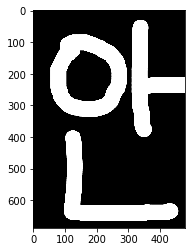

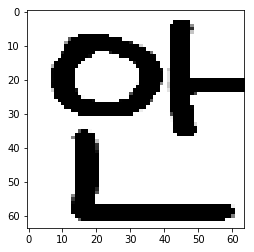

[1]: [안]: -91.91065
[2]: [른]: -104.41744
[3]: [한]: -111.407425
[4]: [간]: -114.321335
[5]: [만]: -119.22146
Prediction: 288
Prediction: 안

288#162#482#2#171#
한글 인식 요청을 받았습니다 client -> serverironman@image_send_client_to_server_hangeul@ctos_image.png@16519

파일 이름 : ctos_image.png
파일 길이 : 16519
파일 수신 완료 : 16519


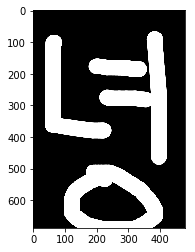

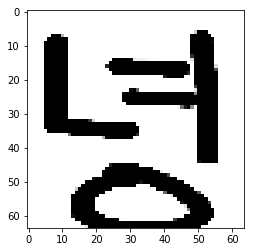

[1]: [넘]: -128.1819
[2]: [년]: -130.79881
[3]: [녕]: -148.40636
[4]: [널]: -152.69318
[5]: [넓]: -152.99269
Prediction: 82
Prediction: 넘

82#87#89#80#81#
뿌린 메시지 : ironman@normal_chatting@안녕
뿌린 메시지 : ironman@normal_chatting@안녕


In [ ]:
import socketserver
import threading
import os # os.path.getsize(path)
import time
 
HOST = ''
PORT = 9100
lock = threading.Lock() # syncronized 동기화 진행하는 스레드 생성

class UserManager: # 사용자관리 및 채팅 메세지 전송을 담당하는 클래스
                   # ① 채팅 서버로 입장한 사용자의 등록
                   # ② 채팅을 종료하는 사용자의 퇴장 관리
                   # ③ 사용자가 입장하고 퇴장하는 관리
                   # ④ 사용자가 입력한 메세지를 채팅 서버에 접속한 모두에게 전송
 
    def __init__(self):
        self.users = {} # 사용자의 등록 정보를 담을 사전 {사용자 이름:(소켓,주소),...}
 
    def addUser(self, username, conn, addr): # 사용자 ID를 self.users에 추가하는 함수
        if username in self.users: # 이미 등록된 사용자라면
            conn.send('이미 등록된 사용자입니다.\n'.encode())
            return None
 
              # 새로운 사용자를 등록함
        lock.acquire() # 스레드 동기화를 막기위한 락
        self.users[username] = (conn, addr)
        lock.release() # 업데이트 후 락 해제

        self.sendMessageToAll('system@normal_chatting@[%s]님이 입장했습니다. \n' %username)
        print('+++ 대화 참여자 수 [%d]' %len(self.users))

        return username
 
    def removeUser(self, username): #사용자를 제거하는 함수
        if username not in self.users:
            return

        lock.acquire()
        del self.users[username]
        lock.release()
 
        self.sendMessageToAll('[%s]님이 퇴장했습니다.' %username)
        print('--- 대화 참여자 수 [%d]' %len(self.users))
 
    def messageHandler(self, username, msg): # 전송한 msg를 처리하는 부분
        
        if msg.split('@')[1] == 'image_send_server_to_client':
            print('파일 전송 요청을 받았습니다 server -> client')
            print(msg)
            file_name = msg.split('@')[2].strip()
            print('파일 이름 : ' + file_name)
            file_size = str(os.path.getsize(file_name))
            print('파일 길이 : ' + file_size)
            #if not exists(file_name): # 파일이 해당 디렉터리에 존재하지 않으면
            #    return # handle()함수를 빠져 나온다.
            self.sendMessageToAll(msg.split('@')[0] + '@image_send_server_to_client@stoc_image.jpg@' + file_size + "\n")
            data_transferred = 0
            with open(file_name, 'rb') as f:
                try:
                    data = f.read(1024) # 파일을 1024바이트 읽음
                    while True: # 파일이 빈 문자열일때까지 반복
                        time.sleep(0.05)
                        self.sendFileToAll(data)
                        data_transferred += len(data)
                        #print(len(data))
                        if data_transferred >= int(file_size):
                            break
                        time.sleep(0.05)
                        data = f.read(1024)
                except Exception as e:
                    print(e)
                f.flush()
                f.close()
            print('전송완료[%s], 전송량[%d]' %(file_name,data_transferred))
            
        else: #msg[0] != '/': # 보낸 메세지의 첫문자가 '/'가 아니면
            self.sendMessageToAll('%s' %(msg))
            return
 
        #if msg.strip() == '/quit': # 보낸 메세지가 'quit'이면
        #    self.removeUser(username)
        #    return -1
 
    def sendMessageToAll(self, msg):
        for conn, addr in self.users.values():
            print('뿌린 메시지 : ' + msg ,end='')
            conn.sendall(msg.encode())
    
    def sendFileToAll(self, msg):
        for conn, addr in self.users.values():
            conn.sendall(msg)
            
           
 
class MyTcpHandler(socketserver.BaseRequestHandler):
    userman = UserManager()
     
    def handle(self): # 클라이언트가 접속시 클라이언트 주소 출력
        print('[%s] 연결됨' %self.client_address[0])
 
        try:
            username = self.registerUsername()
            msg = self.request.recv(1024)
            while msg:
                msg = msg.decode()
                if msg.split('@')[1] == 'image_send_client_to_server':
                    print('파일 전송 요청을 받았습니다 client -> server', end='')
                    print(msg)
                    file_name = msg.split('@')[2].strip()
                    file_length_str = msg.split('@')[3].strip()
                    file_length_int = int(file_length_str)
                    print('파일 이름 : ' + file_name)
                    print('파일 길이 : ' + file_length_str)
                    file_size_count = 0
                   
                    with open(file_name, 'wb') as f:
                        try:
                            data = self.request.recv(1)
                            while data:
                                #print('수신중 : ' + str(data))
                                
                                f.write(data)
                                file_size_count += len(data)
                                if(file_size_count  >= file_length_int):
                                    break
                                data = self.request.recv(1)
                            print('파일 수신 완료 : ' + str(file_size_count))
                            #data = self.request.recv(1024)
                        except Exception as e:
                            print(e)
                    #####
                    
                    
            
                    #####       
                elif msg.split('@')[1] == 'image_send_client_to_server_hangeul':
                    print('한글 인식 요청을 받았습니다 client -> server', end='')
                    print(msg)
                    file_name = msg.split('@')[2].strip()
                    file_length_str = msg.split('@')[3].strip()
                    file_length_int = int(file_length_str)
                    print('파일 이름 : ' + file_name)
                    print('파일 길이 : ' + file_length_str)
                    file_size_count = 0
                   
                    with open(file_name, 'wb') as f:
                        try:
                            data = self.request.recv(1)
                            while data:
                                #print('수신중 : ' + str(data))
                                
                                f.write(data)
                                file_size_count += len(data)
                                if(file_size_count  >= file_length_int):
                                    break
                                data = self.request.recv(1)
                            print('파일 수신 완료 : ' + str(file_size_count))
                            #data = self.request.recv(1024)
                        except Exception as e:
                            print(e)
                    show_hageul_result_list()
                    m = msg.split('@')[0] + "@hangeul_result@" + result_list + "\n"
                    print(result_list) 
                    self.request.sendall(m.encode())
                    
                else: 
                    if self.userman.messageHandler(username, msg) == -1:
                        self.request.close()
                        break
                msg = self.request.recv(1024)
                 
        except Exception as e:
            print(e)
 
        print('[%s] 접속종료' %self.client_address[0])
        self.userman.removeUser(username)
 
    def registerUsername(self):
        while True:
            username = self.request.recv(1024)
            username = username.decode().strip()
            if self.userman.addUser(username, self.request, self.client_address):
                return username
 

class ChatingServer(socketserver.ThreadingMixIn, socketserver.TCPServer):
        pass
         
def runServer():
    print('+++ 채팅 서버를 시작합니다.')
    print('+++ 채팅 서버를 끝내려면 Ctrl-C를 누르세요.')
 
    try:
        server = ChatingServer((HOST, PORT), MyTcpHandler)
        server.serve_forever()
    except KeyboardInterrupt:
        print('--- 채팅 서버를 종료합니다.')
        server.shutdown()
        server.server_close()

        
runServer()